# 8. Simplifying code with PyTorch-Lightning

We have seen in the previous chapter how to train a neural network. Our training loop contained a lot of "boiler-plate" code, i.e. trivial things that we always need, like ```loss.backwards()```, and that we would like to spare us to write. Several libraries offer such possibilities, the most popular one being PyTorch Lightning. We will here briefly rewrite our code of the [Training](Training.ipynb) notebook with this. You will see that we write essentially the same code, save for some boiler-plate.

Another advantage is that the higher-level format offered by Lightning allows us later to simplify complex tasks, like traininig on multiple GPUs.

## Dataloader
We recreate first some previous elements. First our dataset and dataloader:

In [161]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch import nn
from torch.functional import F

import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt

In [162]:
images = np.load('../data/triangle_circle.npy')
labels = np.load('../data/triangle_circle_label.npy')

In [164]:
class Tricircle(Dataset):
    def __init__(self, data, labels, transform=None):
        super(Tricircle, self).__init__()
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        
        x = self.data[index]
        x = torch.tensor(x/255, dtype=torch.float32)
        y = torch.tensor(self.labels[index])
        
        return x, y

    def __len__(self):

        return len(labels)

In [165]:
tridata = Tricircle(images, labels)
test_size = int(0.8 * len(tridata))
valid_size = len(tridata)-test_size

train_data, valid_data = random_split(tridata, [test_size, valid_size])
train_loader = DataLoader(train_data, batch_size=10)
validation_loader = DataLoader(valid_data, batch_size=10)

## Lightning module

Before, we only created an object containing our model and all the remaining tasks - setting up the optimizer, training and validation loop etc. - was done after that "manually". Here, all this additional work is included in our object in specific methods (```training_step```, ```validation_step```, ```configure_optimizers```) sparing us a lot of code later on. For example we won't have to explicitly write epochs and batch loops, take care of calculating gradients, setting them to zeros etc.

You should understand one important feature of Ligthning: the ```forward``` function is used for **inference** (prediction) while the ```training_step``` is used for **training**. Of course one can include the steps of ```forward``` in the training loop but the latter can contain much more information.

The actual difference in code is very small compared to classic PyTorch but brings massive advantages. Of importance in my personal opinion: Lightning *organizes* code and doesn't abstract away complexity. This makes it easy to still do very fine adjustments to the underlying PyTorch code what other higher-level frameworks make difficult.

This was our previous code defining our model:

In [166]:
class Mynetwork(nn.Module):
    def __init__(self, input_size, num_categories):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(input_size, 100)
        self.layer2 = nn.Linear(100, num_categories)

    def forward(self, x):
        
        # flatten the input
        x = x.flatten(start_dim=1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        
        return x

Now we add methods for training, validation and optimizer which are basically copied from our previous work. Note however that we can skip many things, like loops or ```backward()``` calls. The only thing that we are adding are calls to ```self.log``` which allows us to capture and display loss, accuracy etc. information during training.

In [167]:
class Mynetwork(pl.LightningModule):
    def __init__(self, input_size, num_categories):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(input_size, 100)
        self.layer2 = nn.Linear(100, num_categories)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        
        # flatten the input
        x = x.flatten(start_dim=1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        self.log('my_metric', loss, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        accuracy = (torch.argmax(output,dim=1) == y).sum()/len(y)

        self.log('accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)
        
        return accuracy
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


Now we instantiate the Lightning module:

In [168]:
model = Mynetwork(32*32, 2)

## Training

Instead of writing a training loop for epochs and batches, we use the Lightning ```Trainer``` object which takes care of everything for us. We first instantiate it and then pass our model and data loaders for fitting (similarly to scikit-learn methods).

In [169]:
trainer = pl.Trainer(max_epochs=5)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [170]:
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=validation_loader)



  | Name   | Type             | Params
--------------------------------------------
0 | layer1 | Linear           | 102 K 
1 | layer2 | Linear           | 202   
2 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
/Users/gw18g940/miniconda3/envs/CAS/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/gw18g940/miniconda3/envs/CAS/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/gw18g940/miniconda3/envs/CAS/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

## Inference

To check that trainig worked, we just generate again some images:

In [171]:
im_type = ['triangle', 'circle']

from skimage.draw import random_shapes
def make_image(shape):
    """Generate image of given shape scaled 0-1."""
    
    image, _ = random_shapes((32,32),max_shapes=1, min_shapes=1, multichannel=False, shape=shape,
                                min_size=8)
    #normalize
    image = (255-image)/255

    # turn into tensor
    image_tensor = torch.tensor(image,dtype=torch.float32)
    
    return image_tensor

In [172]:
label = torch.tensor(np.random.randint(0,2,100))
mybatch = torch.stack([make_image(im_type[x]) for x in label])

In [173]:
mybatch.size()

torch.Size([100, 32, 32])

In [174]:
pred = model(mybatch)

In [175]:
pred.argmax(dim=1)

tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0])

In [176]:
label

tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0])

In [177]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [178]:
df_cm = pd.DataFrame(confusion_matrix(pred.argmax(dim=1), label), index = im_type,
                  columns = im_type)

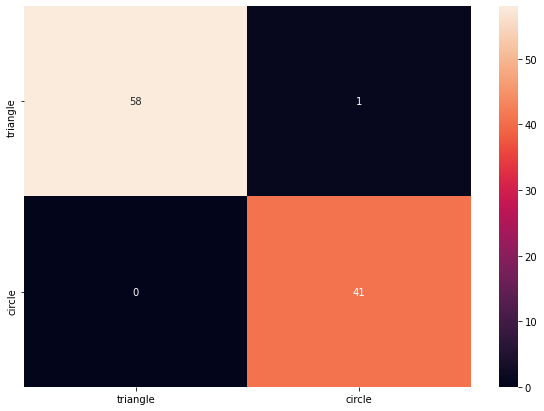

In [179]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True);

## Using a logger

It is very common to use an additional tool to follow the progress of training. A very popular tool is TensorBoard. To use it with PyTorch Lightening, we can simply attach a TensorBoard logger to our trainer.

In [193]:
class Mynetwork(pl.LightningModule):
    def __init__(self, input_size, num_categories):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.layer1 = nn.Linear(input_size, 100)
        self.layer2 = nn.Linear(100, num_categories)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        
        # flatten the input
        x = x.flatten(start_dim=1)
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        
        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum()/len(y)
        
        self.log('loss', loss, on_epoch=True, prog_bar=True, logger=False)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)
        self.logger.experiment.add_scalar("Accuracy/Train", accuracy, self.current_epoch)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        
        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum()/len(y)

        self.log('accuracy', accuracy, on_epoch=True, prog_bar=True, logger=False)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)
        self.logger.experiment.add_scalar("Accuracy/Valid", accuracy, self.current_epoch)
        
        return accuracy
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [198]:
model = Mynetwork(32*32, 2)

We added here logging of the accuracy and loss for both training and validation using the ```add_scalar``` method. You can find more details in the [PyTorch API](https://pytorch.org/docs/stable/tensorboard.html).

Now we create a tensorboard logger and pass it to our trainer:

In [200]:
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="my_model")
trainer = pl.Trainer(logger=logger, max_epochs=10)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [201]:
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=validation_loader)


  | Name   | Type             | Params
--------------------------------------------
0 | layer1 | Linear           | 102 K 
1 | layer2 | Linear           | 202   
2 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
/Users/gw18g940/miniconda3/envs/CAS/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/gw18g940/miniconda3/envs/CAS/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/gw18g940/miniconda3/envs/CAS/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [186]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [199]:
%tensorboard --logdir tb_logs

## Running on the GPU

We have seen in a previous notebook that in order to use a GPU we need to send models and data to it. This is much simplified with Lightning, as you just have to tell the trainer to use a GPU:

In [ ]:
trainer = pl.Trainer(logger=logger, max_epochs=10, gpus=1)